# Filtered Back Projection
The goal of this project is to get a better understanding of CT reconstruction algorithms.

There are three questions in this exercise:

1. Use Stanford bunny CT scan data to create two different datasets with step angles = {0.5, 3}, corresponding to well-sampled and under-sampled cases, using parallel projections over an 180 arc. Display projections in sinograms.
2. Use the two datasets of projections. Reconstruct images via filtered back projection. Display the reconstructed images. Comment on the image quality in the two images and on the advantages and disadvantages associated with each case.
3. For the well sampled dataset (step angle=0.5), use each of the following filters ('Ram-Lak', 'Hamming', 'Hann’) for reconstruction. Plot the filter response both in spatial and frequency domain. For each case, compute the Root Mean Square Error between the reconstructed image and the original phantom image. Use the root mean square error to evaluate each filter’s performance.


In [236]:
from __future__ import print_function, division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from skimage import transform as tf
from skimage.transform import rotate
from skimage.transform import radon, rescale
from skimage.io import imread,imshow
from skimage.transform import iradon
from tqdm import tqdm

### 1.1 - Dataset

The dataset can be downloaded from http://graphics.stanford.edu/data/voldata/bunny-ctscan.tar.gz

The description of the dataset: http://graphics.stanford.edu/data/voldata/voldata.html#bunny
http://graphics.stanford.edu/data/voldata/bunny-README

<center>
<img src="http://graphics.stanford.edu/data/voldata/bunny-ctslice-247.jpg" style="width:256px;height:256px;">
<caption><center> **Figure 1**: Stanford terra-cotta bunny.</center></caption>
</center>

- Description: The dataset is a CT scan of the Stanford terra-cotta bunny
- Dimensions: 360 slices of 512 x 512 pixels voxel grid is rectangular, and X:Y:Z aspect ratio of each voxel is 1:1:1
- Files: 360 binary files, one file per slice
- File format: 16-bit integers (Mac byte ordering), file contains no header
- Data source: Terry Yoo of the National Library of Medicine, using a scanner provided by Sandy Napel and Geoff Rubin of Stanford Radiology, of the terra-cotta bunny provided by Marc Levoy of Stanford CS

Read the images and convert them to a 361x512x512 numpy array.

In [2]:
root = os.path.join(os.curdir,'bunny')
files = os.listdir(root)
paths = [os.path.join(root, s) for s in files]
images = [np.fromfile(path,dtype='>i2',sep="").reshape([512,512]) for path in paths]

In [3]:
images = np.array(images)

In [4]:
images.shape

(361, 512, 512)

In [5]:
images[160]

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

In [6]:
# import pickle
# output = open('data.pkl','wb')
# pickle.dump(images,output)
# output.close()

Choose two slices from the dataset randomly and visualize them.

In [225]:
idx1 = 160
idx2 = 210

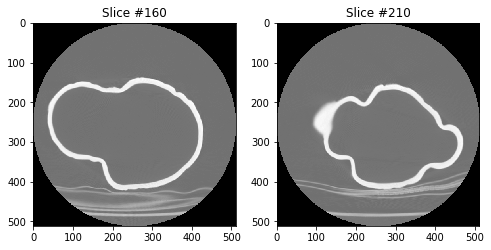

In [227]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 8))
ax1.set_title("Slice #"+str(idx1))
ax1.imshow(images[idx1,:,:], cmap='gray')
ax2.set_title("Slice #"+str(idx2))
ax2.imshow(images[idx2,:,:], cmap='gray')

### 1.2 - Parallel Projections
A parallel projection is a projection of an object in three-dimensional space onto a fixed plane, known as the projection plane or image plane, where the rays, known as lines of sight or projection lines, are parallel to each other.

<center>
<img src="https://www.researchgate.net/profile/Yurong_Gao/publication/261743290/figure/fig5/AS:267743610011658@1440846459259/Radon-transform-of-a-convex-object-permits-full-width-at-half-maximum-FWHM.png" style="width:256px;height:256px;">
<caption><center> **Figure 2**: Radon Transform</center></caption>
</center>

Here, we should create two different datasets with step angles = {0.5 degree, 3 degree}. For the dataset of 0.5 degree step projection, we will get a 361x512x360 three dimensional sinograms. For the dataset of 3 degree step projection, we will get a 361x512x60 three dimensional sinograms. 

Create the sinogram of the dataset for the 0.5 degree step projection.  It may take a while to run.

In [229]:
theta_1 = np.linspace(0., 180., 360, endpoint=False)
sinogram_1 = []
for i in tqdm(range(0,images.shape[0])):
    sinogram_1.append(radon(images[i,:,:], theta=theta_1, circle=False))
sinogram_1 = np.asarray(sinogram_1)

In [233]:
sinogram_1.shape

(361, 725, 360)

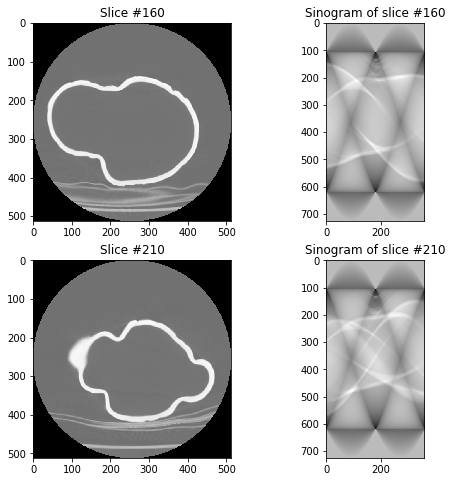

In [234]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
ax[0,0].set_title("Slice #"+str(idx1))
ax[0,0].imshow(images[idx1,:,:], cmap='gray')
ax[0,1].set_title("Sinogram of slice #"+str(idx1))
ax[0,1].imshow(sinogram_1[idx1,:,:], cmap='gray')
ax[1,0].set_title("Slice #"+str(idx2))
ax[1,0].imshow(images[idx2,:,:], cmap='gray')
ax[1,1].set_title("Sinogram of slice #"+str(idx2))
ax[1,1].imshow(sinogram_1[idx2,:,:], cmap='gray')

Create the sinogram of the dataset for the 3 degree step projection. It may take a while to run.

In [241]:
theta_2 = np.linspace(0., 180., 60, endpoint=False)
sinogram_2 = []
for i in tqdm(range(0,images.shape[0])):
    sinogram_2.append(radon(images[i,:,:], theta=theta_2, circle=False))
sinogram_2 = np.asarray(sinogram_2)

100%|████████████████████████████████████████| 361/361 [10:27<00:00,  1.74s/it]


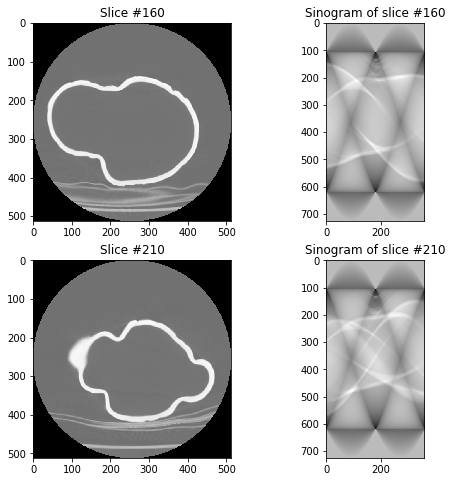

In [243]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))
ax[0,0].set_title("Slice #"+str(idx1))
ax[0,0].imshow(images[idx1,:,:], cmap='gray')
ax[0,1].set_title("Sinogram of slice #"+str(idx1))
ax[0,1].imshow(sinogram_1[idx1,:,:], cmap='gray')
ax[1,0].set_title("Slice #"+str(idx2))
ax[1,0].imshow(images[idx2,:,:], cmap='gray')
ax[1,1].set_title("Sinogram of slice #"+str(idx2))
ax[1,1].imshow(sinogram_1[idx2,:,:], cmap='gray')

### 2 - Reconstruct images via filtered back projection

- Image reconstruction from a series of projections
- Projection recon is the earliest and still the most widely used type of CT
- One of the principal applications of DIP in medicine

<center>
<img src="./images/backprojection_0.png" style="width:325px;height:256px;">
<caption><center> **Figure 3**: Back Projection</center></caption>
</center>



Reconstruct the image from the 0.5 degree step projection sinogram. Here use Ramp filter. It may take a while to run.

In [237]:
reconstruction_1 = np.zeros((361, 512, 512))
RMSE_1 = []
for i in tqdm(range(0, sinogram_1.shape[0])):
    reconstruction_1[i,:,:] = iradon(sinogram_1[i,:,:], theta=theta_1, circle=False)
    error = reconstruction_1[i,:,:] - images[i,:,:]
    RMSE_1.append(np.sqrt(np.mean(error**2)))

100%|████████████████████████████████████████| 361/361 [16:09<00:00,  2.68s/it]


FBP rms reconstruction error: 66.3452


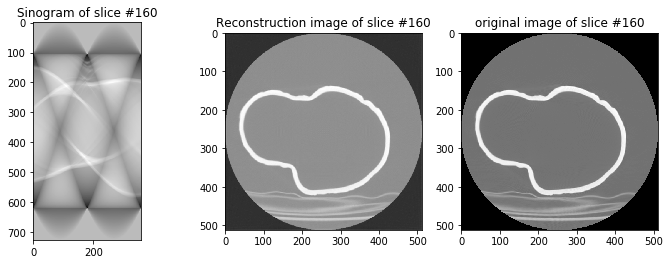

In [239]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].set_title("Sinogram of slice #"+str(idx1))
ax[0].imshow(sinogram_1[idx1,:,:], cmap='gray')
ax[1].set_title("Reconstruction image of slice #"+str(idx1))
ax[1].imshow(reconstruction_1[idx1,:,:], cmap='gray')
ax[2].set_title("original image of slice #"+str(idx1))
ax[2].imshow(images[idx1,:,:], cmap='gray')

print('FBP rms reconstruction error: %g' % RMSE_1[idx1])

Reconstruct the image from the 3 degree step projection sinogram. It may take a while to run.

In [244]:
reconstruction_2 = np.zeros((361, 512, 512))
RMSE_2 = []
for i in tqdm(range(0, sinogram_2.shape[0])):
    reconstruction_2[i,:,:] = iradon(sinogram_2[i,:,:], theta=theta_2, circle=False)
    error = reconstruction_2[i,:,:] - images[i,:,:]
    RMSE_2.append(np.sqrt(np.mean(error**2)))

100%|████████████████████████████████████████| 361/361 [03:23<00:00,  1.77it/s]


FBP rms reconstruction error: 538.641


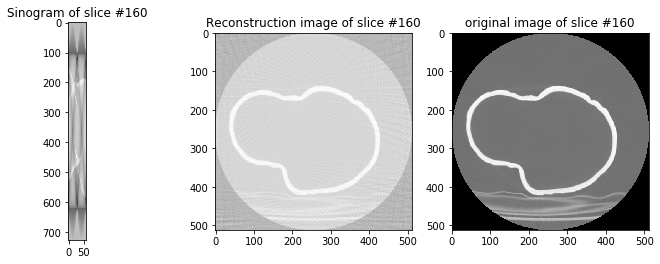

In [246]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].set_title("Sinogram of slice #"+str(idx1))
ax[0].imshow(sinogram_2[idx1,:,:], cmap='gray')
ax[1].set_title("Reconstruction image of slice #"+str(idx1))
ax[1].imshow(reconstruction_2[idx1,:,:], cmap='gray')
ax[2].set_title("original image of slice #"+str(idx1))
ax[2].imshow(images[idx1,:,:], cmap='gray')

print('FBP rms reconstruction error: %g' % RMSE_2[idx1])

From the two figures above, we can find that the reconstruction image of 0.5 degree step is more clear than the reconstruction image of 0 degree step. Also, the FBP root mean square error can prove it since the FBP rms reconstruction error of 0.5 degree step is 3105.57 but the FBP rms reconstruction error of 3 degree step is 7867.58

### 3 - Reconstruct images using the specific filters

For the well sampled dataset (step angle=0.5), use each of the following filters for reconstruction. 
- 'Ram-Lak' filter
- 'Hamming' filter
- 'Hann' filter

Plot the filter response both in spatial and frequency domain. For each case, compute the Root Mean Square Error between the reconstructed image and the original phantom image. Use the root mean square error to evaluate each filter’s performance.

Reconstruct using 'Ram-Lak' filter, since we already used Ram-Lak filter(default) above, here just plot the results.

FBP rms reconstruction error: 66.3452


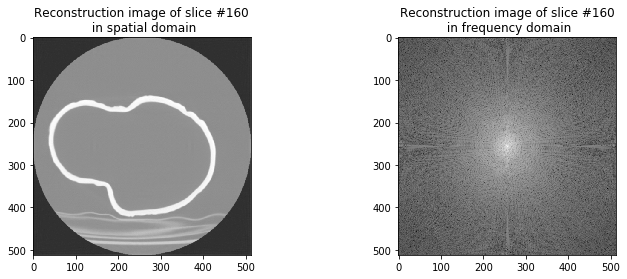

In [249]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].set_title("Reconstruction image of slice #"+str(idx1)+"\n in spatial domain")
ax[0].imshow(reconstruction_1[idx1,:,:], cmap='gray')
ax[1].set_title("Reconstruction image of slice #"+str(idx1)+"\n in frequency domain")
f = np.fft.fft2(reconstruction_1[idx1,:,:])
fshift = np.fft.fftshift(f)
ax[1].imshow(20*np.log(np.abs(fshift)), cmap='gray')

print('FBP rms reconstruction error: %g' % RMSE_1[idx1])

Reconstruct using 'Hamming' filter

In [250]:
reconstruction_hamming = np.zeros((361, 512, 512))
RMSE_hamming = []
for i in tqdm(range(0, sinogram_1.shape[0])):
    reconstruction_hamming[i,:,:] = iradon(sinogram_1[i,:,:], theta=theta_1, filter ='hamming', circle=False)
    error = reconstruction_hamming[i,:,:] - images[i,:,:]
    RMSE_hamming.append(np.sqrt(np.mean(error**2)))

100%|████████████████████████████████████████| 361/361 [19:56<00:00,  3.31s/it]


FBP rms reconstruction error: 63.5284


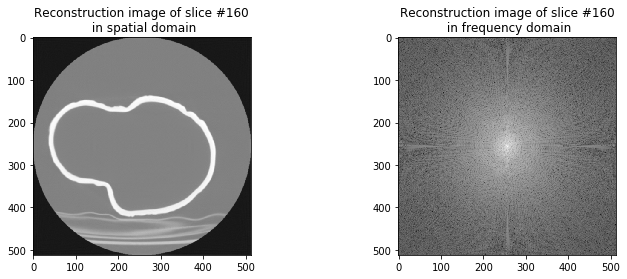

In [251]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].set_title("Reconstruction image of slice #"+str(idx1)+"\n in spatial domain")
ax[0].imshow(reconstruction_hamming[idx1,:,:], cmap='gray')
ax[1].set_title("Reconstruction image of slice #"+str(idx1)+"\n in frequency domain")
f = np.fft.fft2(reconstruction_hamming[idx1,:,:])
fshift = np.fft.fftshift(f)
ax[1].imshow(20*np.log(np.abs(fshift)), cmap='gray')

print('FBP rms reconstruction error: %g' % RMSE_hamming[idx1])

Reconstruct using 'Hann' filter

In [252]:
reconstruction_hann = np.zeros((361, 512, 512))
RMSE_hann = []
for i in tqdm(range(0, sinogram_1.shape[0])):
    reconstruction_hann[i,:,:] = iradon(sinogram_1[i,:,:], theta=theta_1, filter ='hann', circle=False)
    error = reconstruction_hann[i,:,:] - images[i,:,:]
    RMSE_hann.append(np.sqrt(np.mean(error**2)))

100%|████████████████████████████████████████| 361/361 [19:47<00:00,  3.29s/it]


FBP rms reconstruction error: 63.8987


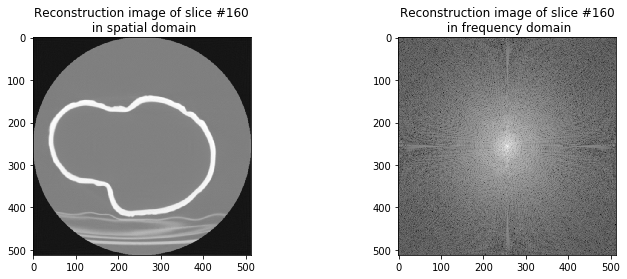

In [253]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].set_title("Reconstruction image of slice #"+str(idx1)+"\n in spatial domain")
ax[0].imshow(reconstruction_hann[idx1,:,:], cmap='gray')
ax[1].set_title("Reconstruction image of slice #"+str(idx1)+"\n in frequency domain")
f = np.fft.fft2(reconstruction_hann[idx1,:,:])
fshift = np.fft.fftshift(f)
ax[1].imshow(20*np.log(np.abs(fshift)), cmap='gray')

print('FBP rms reconstruction error: %g' % RMSE_hann[idx1])

### Conclusion

The FBP rms reconstruction error of 'Ram-Lak' filter, 'Hamming' filter and 'Hann' filter are 66.3452, 63.5284 and 63.8987, seperately. As a conclusion, for this dataset, the 'Hamming' filter achieves lowest reconstruction error.

## References: 
https://en.wikipedia.org/wiki/Parallel_projection
https://www.researchgate.net/profile/Yurong_Gao/publication/261743290/figure/fig5/AS:267743610011658@1440846459259/Radon-transform-of-a-convex-object-permits-full-width-at-half-maximum-FWHM.png
http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.algorithm.html